<a href="https://colab.research.google.com/github/joaosMart/fish-species-class-siglip/blob/main/Code/Fish_Detection_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fish Detection Model Comparison and Prompt Engineering

This notebook evaluates different SigLIP and CLIP architectures for zero-shot fish detection
in underwater monitoring footage, implementing the methodology described in:
"Temporal Aggregation of Vision-Language Features for High-Accuracy Fish Classification in Automated Monitoring"

## Key Results:
- ViT-SO400M-14-SigLIP achieves 99.1% F1-score for fish detection
- Ensemble prompt engineering improves classification robustness
- SigLIP models consistently outperform standard CLIP architectures

## Installation and Setup

Install required packages

!pip install transformers open_clip_torch

In [ ]:
!pip install transformers open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [ ]:
import os
import glob
import cv2
import pandas as pd
import pickle
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn.functional as F
import open_clip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
from matplotlib.ticker import FuncFormatter
from matplotlib.font_manager import FontProperties

# Set up device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Dataset Preparation

In [ ]:

def setup_dataset():
    """Setup instructions for downloading the dataset."""

    if os.path.exists("fish_dataset"):
        print("✅ Dataset already exists!")
        return True

    print("📋 DATASET SETUP REQUIRED:")
    print("1. Go to: https://drive.google.com/drive/folders/1BAfJ8vT-DW_dbzK-oM0bzZDSMX-r-5nA?usp=drive_link")
    print("2. Right-click the folder → Download")
    print("3. Google Drive will automatically create a ZIP file")
    print("4. Upload the ZIP to Colab using the file upload button")
    print("5. Run the extraction cell below")

    return False

def extract_uploaded_dataset(path_to_zip):
    """Extract dataset after manual upload."""

    from google.colab import files
    import zipfile


    # Extract
    with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
        zip_ref.extractall("./detection_data")

    # Remove ZIP
    os.remove(path_to_zip)
    print("✅ Dataset extracted!")

# Usage in your notebook:
if not setup_dataset():
    # If dataset doesn't exist, show upload option
    extract_uploaded_dataset("/content/validation_set-20250804T135239Z-1-001.zip")

📋 DATASET SETUP REQUIRED:
1. Go to: https://drive.google.com/drive/folders/YOUR_FOLDER_ID
2. Right-click the folder → Download
3. Google Drive will automatically create a ZIP file
4. Upload the ZIP to Colab using the file upload button
5. Run the extraction cell below
✅ Dataset extracted!


In [ ]:
# Update these paths to match your dataset structure
positive_images = glob.glob("/content/detection_data/validation_set/fish/*.jpg")
negative_images = glob.glob("/content/detection_data/validation_set/no_fish/*.jpg")

print(f"Found {len(positive_images)} positive images and {len(negative_images)} negative images")
print(f"Total validation dataset: {len(positive_images) + len(negative_images)} images")

Found 168 positive images and 163 negative images
Total validation dataset: 331 images


## Model Architecture Comparison

In [ ]:
# Define model architectures and their pretrained checkpoints
# Based on Table 2 from the paper
model_configurations = [
    ['ViT-B-16-SigLIP', 'webli'],
    ['ViT-SO400M-14-SigLIP-384', 'webli'],
    ['ViT-B-16-SigLIP-384', 'webli'],
    ['ViT-SO400M-14-SigLIP', 'webli'],
    ['ViT-B-16-SigLIP-512', 'webli'],
    ['ViT-B-32', 'laion2b_s34b_b79k'],
    ['ViT-L-14', 'laion2b_s32b_b82k'],
    ['ViT-H-14', 'laion2b_s32b_b79k'],
    ['EVA02-L-14-336', 'merged2b_s6b_b61k']
]

# Simple text prompts for initial model comparison
text_inputs = [
    "A salmon-like fish swimming",
    "A container in a river with nothing in it."
]

def evaluate_model_architecture(model_name, checkpoint, positive_imgs, negative_imgs, text_prompts):
    """
    Evaluate a single model architecture on the fish detection task.

    Args:
        model_name (str): Name of the model architecture
        checkpoint (str): Pretrained checkpoint identifier
        positive_imgs (list): List of paths to positive images
        negative_imgs (list): List of paths to negative images
        text_prompts (list): Text prompts for zero-shot classification

    Returns:
        list: Results containing class labels and probabilities
    """
    print(f"Evaluating {model_name} with {checkpoint}")

    # Load model and preprocessing
    model, _, preprocess_val = open_clip.create_model_and_transforms(
        model_name, pretrained=checkpoint
    )
    model = model.to(device)
    tokenizer = open_clip.get_tokenizer(model_name)

    # Encode text prompts
    text = tokenizer(text_prompts, context_length=model.context_length).to(device)
    with torch.no_grad(), torch.cuda.amp.autocast():
        text_features = F.normalize(model.encode_text(text), dim=-1)

    results = []
    batch_size = 32

    # Process positive and negative images
    for image_class, image_list in [(1, positive_imgs), (0, negative_imgs)]:
        for i in tqdm(range(0, len(image_list), batch_size),
                     desc=f"Processing {'positive' if image_class else 'negative'} images"):
            batch = image_list[i:i+batch_size]

            # Load and preprocess batch
            images = torch.stack([
                preprocess_val(Image.open(img_path)).to(device)
                for img_path in batch
            ])

            # Get image features and compute similarities
            with torch.no_grad(), torch.cuda.amp.autocast():
                image_features = F.normalize(model.encode_image(images), dim=-1)
                text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

            # Store results
            for prob in text_probs:
                results.append([image_class, prob.cpu()])

    # Clear GPU memory
    torch.cuda.empty_cache()

    return results

# Validting all model architectures
print("=" * 60)
print("VALIDATING MODEL ARCHITECTURES FOR FISH DETECTION")
print("=" * 60)

model_results = {}

for model_name, checkpoint in model_configurations:
    try:
        results = evaluate_model_architecture(
            model_name, checkpoint, positive_images, negative_images, text_inputs
        )
        model_results[model_name] = results
        print(f"✓ Successfully evaluated {model_name}")
    except Exception as e:
        print(f"✗ Failed to evaluate {model_name}: {str(e)}")
    print("-" * 40)

VALIDATING MODEL ARCHITECTURES FOR FISH DETECTION
Evaluating ViT-B-16-SigLIP with webli


/tmp/ipython-input-3888074197.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
Processing positive images:   0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipython-input-3888074197.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
Processing negative images: 100%|██████████| 6/6 [00:01<00:00,  5.56it/s]


✓ Successfully evaluated ViT-B-16-SigLIP
----------------------------------------
Evaluating ViT-SO400M-14-SigLIP-384 with webli


Processing negative images: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]


✓ Successfully evaluated ViT-SO400M-14-SigLIP-384
----------------------------------------
Evaluating ViT-B-16-SigLIP-384 with webli


Processing negative images: 100%|██████████| 6/6 [00:01<00:00,  3.24it/s]


✓ Successfully evaluated ViT-B-16-SigLIP-384
----------------------------------------
Evaluating ViT-SO400M-14-SigLIP with webli


Processing negative images: 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]


✓ Successfully evaluated ViT-SO400M-14-SigLIP
----------------------------------------
Evaluating ViT-B-16-SigLIP-512 with webli


Processing negative images: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]


✓ Successfully evaluated ViT-B-16-SigLIP-512
----------------------------------------
Evaluating ViT-B-32 with laion2b_s34b_b79k


Processing negative images: 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


✓ Successfully evaluated ViT-B-32
----------------------------------------
Evaluating ViT-L-14 with laion2b_s32b_b82k


Processing negative images: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


✓ Successfully evaluated ViT-L-14
----------------------------------------
Evaluating ViT-H-14 with laion2b_s32b_b79k


Processing negative images: 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]


✓ Successfully evaluated ViT-H-14
----------------------------------------
Evaluating EVA02-L-14-336 with merged2b_s6b_b61k


Processing negative images: 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]

✓ Successfully evaluated EVA02-L-14-336
----------------------------------------


## Visualization: Model Performance Comparison

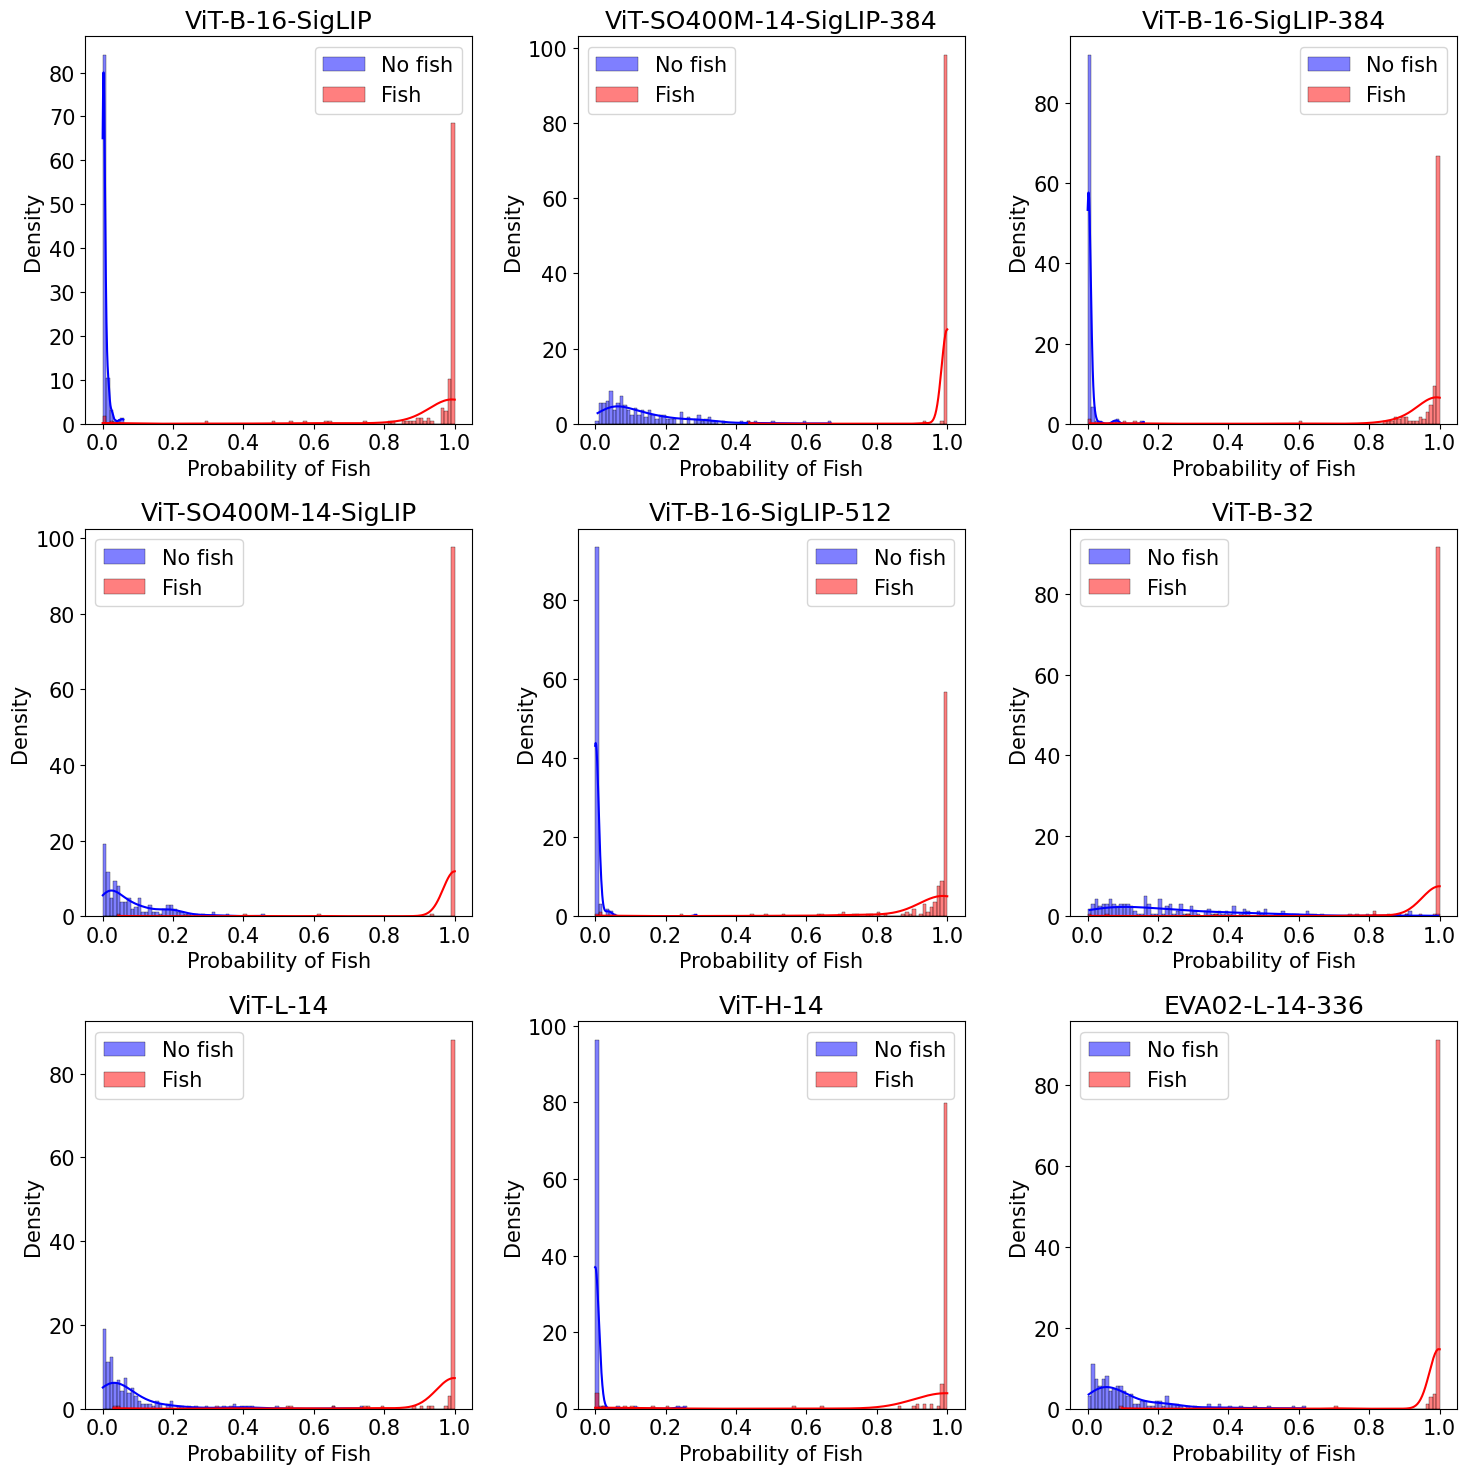

In [ ]:
def plot_model_comparison(results_dict):
    """Create comparison plots for different model architectures."""

    plt.rcParams.update({'font.size': 15})
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    axs = axs.flatten()

    for idx, (model_name, results) in enumerate(results_dict.items()):
        if idx >= len(axs):
            break

        ax = axs[idx]

        # Separate probabilities by class
        no_fish_probs = [prob.tolist()[0] for class_label, prob in results if class_label == 0]
        fish_probs = [prob.tolist()[0] for class_label, prob in results if class_label == 1]

        # Create histograms
        bins = [x/100 for x in range(101)]
        sns.histplot(no_fish_probs, bins=bins, color='blue', kde=True,
                    label='No fish', stat="density", ax=ax)
        sns.histplot(fish_probs, bins=bins, color='red', kde=True,
                    label='Fish', stat="density", ax=ax)

        ax.set_xlabel('Probability of Fish')
        ax.set_ylabel('Density')
        ax.legend()
        ax.set_title(model_name)

    plt.tight_layout()
    plt.savefig("model_comparison_distributions.png", dpi=300, bbox_inches='tight')
    plt.show()

# Plot model comparison
plot_model_comparison(model_results)

## F1-Score Analysis Across Thresholds

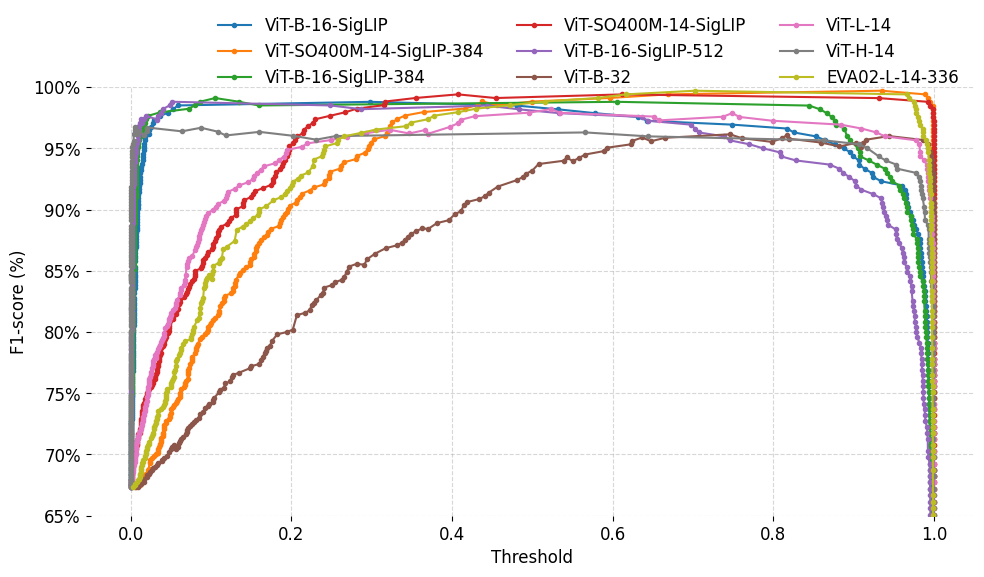

Model performance data saved to 'model_performance_data.csv'


In [ ]:
def analyze_f1_scores(results_dict):
    """Analyze F1-scores across different thresholds for all models."""

    def to_percentage(x, pos):
        return f'{int(x)}%'

    plt.figure(figsize=(10, 6))
    plt.rcParams.update({'font.size': 12})

    all_data = []

    for model_name, results in results_dict.items():
        # Extract true labels and predicted probabilities
        true_classes = [item[0] for item in results]
        predicted_probs = [item[1].tolist()[0] for item in results]

        # Compute precision-recall curve
        precision, recall, thresholds = precision_recall_curve(true_classes, predicted_probs)
        thresholds = np.append(thresholds, 1)  # Add final threshold

        # Compute F1 scores as percentages
        f1_scores = 2 * (precision * recall) / (precision + recall) * 100
        f1_scores = np.nan_to_num(f1_scores)

        # Plot F1 curve
        plt.plot(thresholds, f1_scores, label=model_name, marker='.')

        # Store data for export
        model_data = pd.DataFrame({
            'Threshold': thresholds,
            'F1-Score': f1_scores,
            'Model': model_name
        })
        all_data.append(model_data)

    # Format plot
    plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percentage))
    plt.xlabel('Threshold')
    plt.ylabel('F1-score (%)')
    plt.ylim(65, 100)
    plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.20), ncol=3, frameon=False)
    plt.grid(True, linestyle='--', alpha=0.5)

    # Remove frame
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    plt.savefig("f1_score_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Save performance data
    combined_data = pd.concat(all_data)
    combined_data.to_csv('model_performance_data.csv', index=False)
    print("Model performance data saved to 'model_performance_data.csv'")

    return combined_data

# Analyze F1 scores
performance_data = analyze_f1_scores(model_results)



## Best Model Selection

In [ ]:
# Based on the paper results, select the best performing model
BEST_MODEL = "ViT-SO400M-14-SigLIP"
BEST_CHECKPOINT = "webli"

print("=" * 60)
print("BEST MODEL SELECTION")
print("=" * 60)
print(f"Selected model: {BEST_MODEL}")
print(f"Checkpoint: {BEST_CHECKPOINT}")
print("This model achieved 99.4% F1-score in the paper evaluation")

BEST MODEL SELECTION
Selected model: ViT-SO400M-14-SigLIP
Checkpoint: webli
This model achieved 99.4% F1-score in the paper evaluation


## Prompt Engineering for Fish Detection

PROMPT ENGINEERING EVALUATION
Evaluating prompt ensemble with ViT-SO400M-14-SigLIP


/tmp/ipython-input-768211873.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
/tmp/ipython-input-768211873.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


✓ Evaluated 331 images with prompt ensemble
COMPREHENSIVE PROMPT ENGINEERING EVALUATION
Evaluating prompt ensemble with ViT-SO400M-14-SigLIP
✓ Evaluated 331 images with comprehensive prompt analysis

Generating ROC curve analysis...


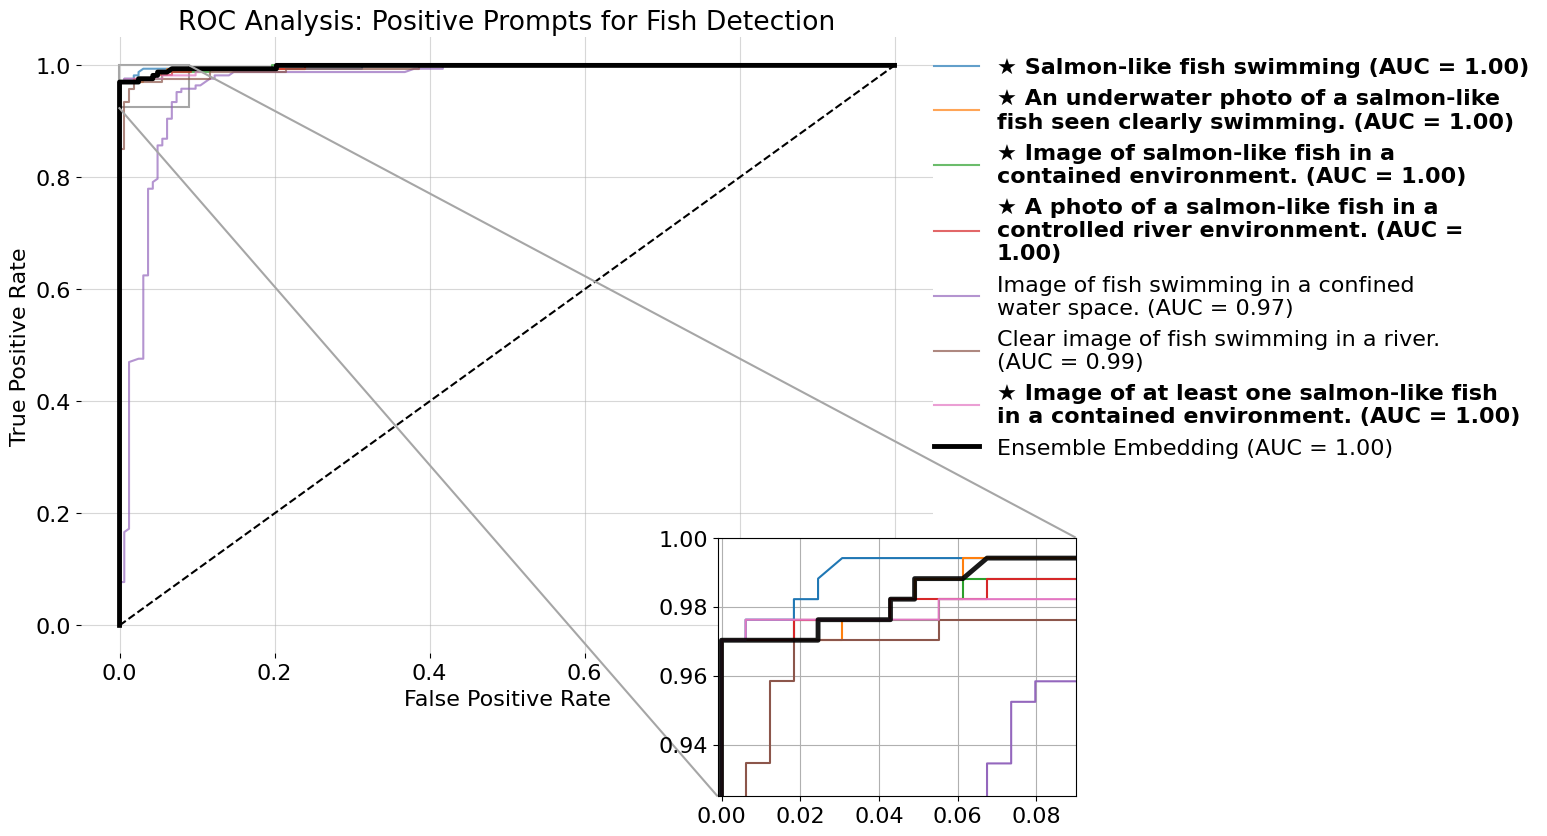

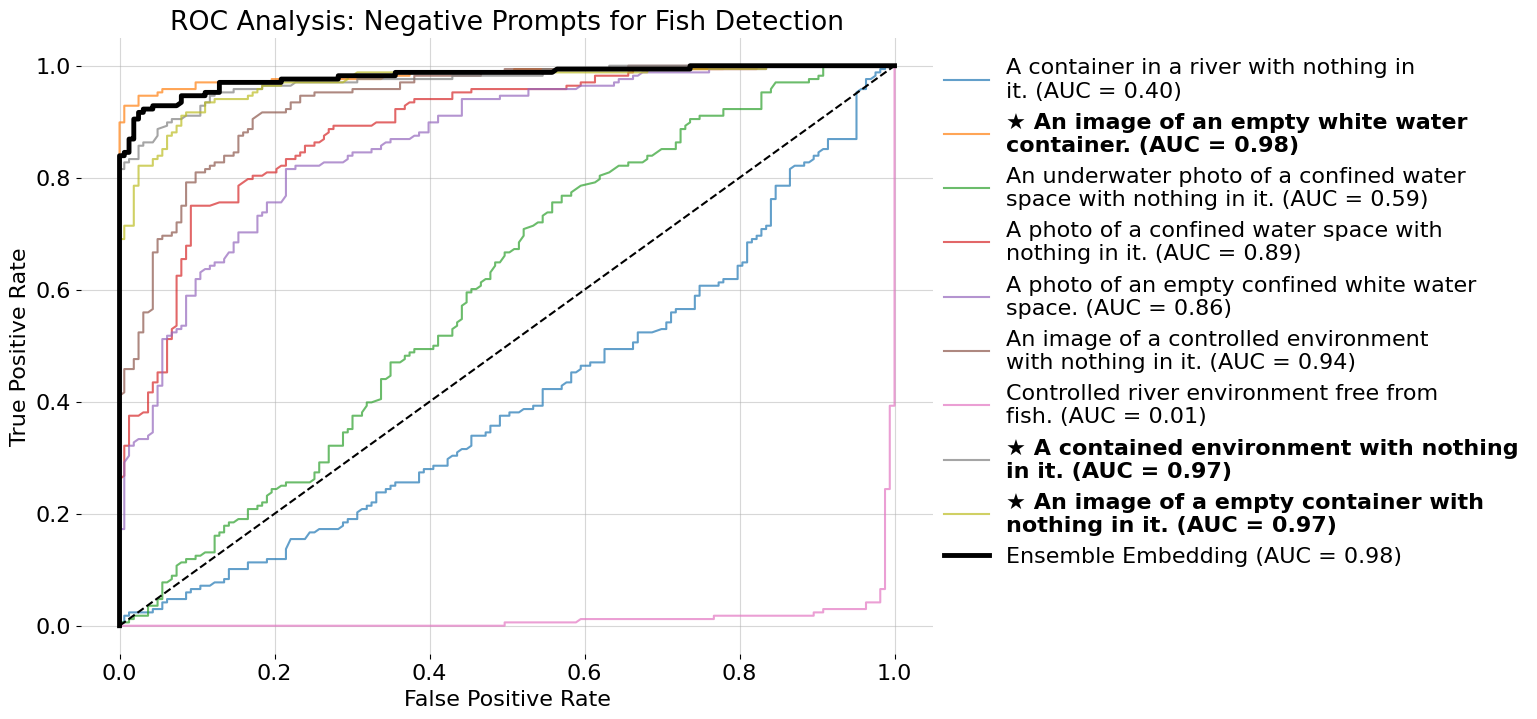

Generating similarity score analysis...


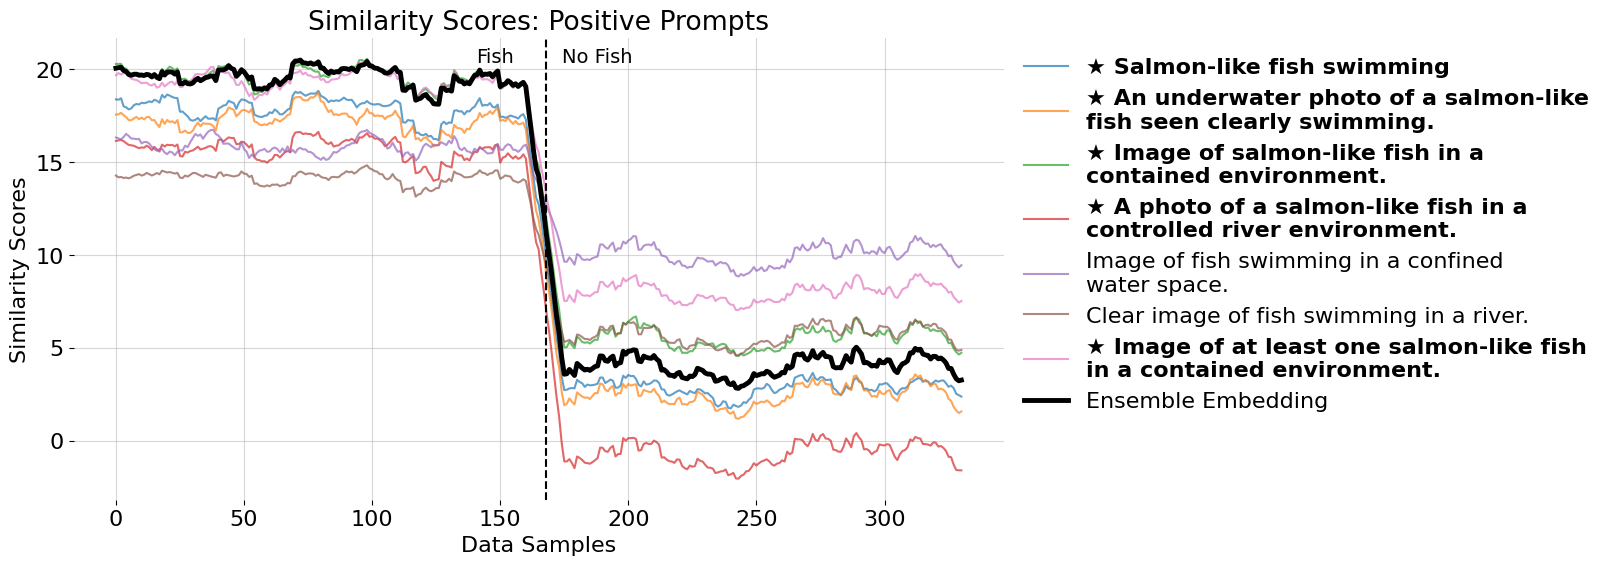

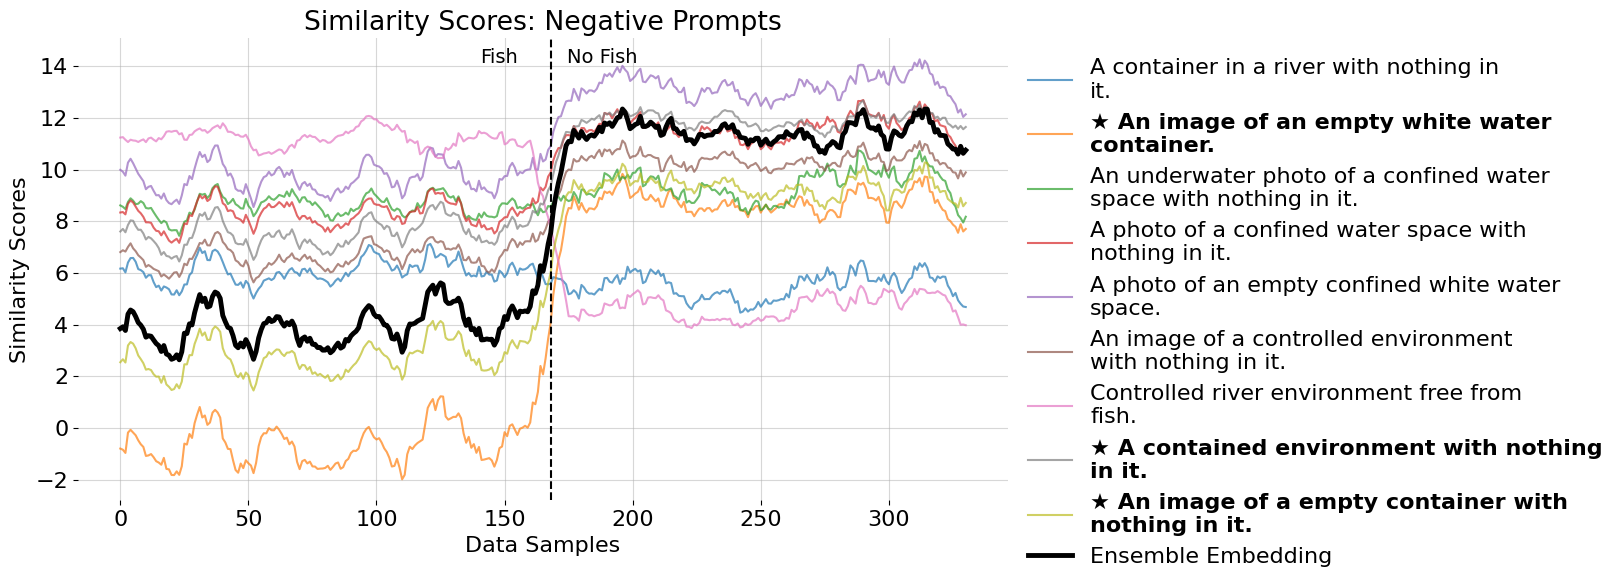

EXPERIMENT SUMMARY
Dataset: 168 fish images, 163 no-fish images
Models evaluated: 9
Best model: ViT-SO400M-14-SigLIP
Positive prompts tested: 7
Negative prompts tested: 9

Prompt Engineering Results:
Ensemble AUC: 0.998
Best individual prompt AUC: 0.998
Best individual prompt: Salmon-like fish swimming...
Ensemble improvement: +0.000

Key Findings:
• SigLIP models consistently outperform standard CLIP architectures
• ViT-SO400M-14-SigLIP achieves best balance of performance and stability
• Ensemble prompting with environmental context improves robustness
• Task-specific prompt engineering essential for zero-shot performance
• Chosen prompts (★) form optimal ensemble for fish detection

SELECTED PROMPT ENSEMBLE
Positive Prompts (Fish Detection):
  1. Salmon-like fish swimming
  2. An underwater photo of a salmon-like fish seen clearly swimming.
  3. Image of salmon-like fish in a contained environment.
  4. A photo of a salmon-like fish in a controlled river environment.
  5. Image of a

In [ ]:
# Define comprehensive prompt sets based on paper methodology
positive_prompts = [
    "Salmon-like fish swimming",
    "An underwater photo of a salmon-like fish seen clearly swimming.",
    "Image of salmon-like fish in a contained environment.",
    "A photo of a salmon-like fish in a controlled river environment.",
    "Image of fish swimming in a confined water space.",
    "Clear image of fish swimming in a river.",
    "Image of at least one salmon-like fish in a contained environment."
]

negative_prompts = [
    "A container in a river with nothing in it.",
    "An image of an empty white water container.",
    "An underwater photo of a confined water space with nothing in it.",
    "A photo of a confined water space with nothing in it.",
    "A photo of an empty confined white water space.",
    "An image of a controlled environment with nothing in it.",
    "Controlled river environment free from fish.",
    "A contained environment with nothing in it.",
    "An image of a empty container with nothing in it."
]

# Best performing prompts (marked with stars in the paper)
chosen_fish_prompts = [
    "Salmon-like fish swimming",
    "An underwater photo of a salmon-like fish seen clearly swimming.",
    "Image of salmon-like fish in a contained environment.",
    "A photo of a salmon-like fish in a controlled river environment.",
    "Image of at least one salmon-like fish in a contained environment."
]

chosen_no_fish_prompts = [
    "An image of an empty white water container.",
    "A contained environment with nothing in it.",
    "An image of a empty container with nothing in it."
]

def evaluate_prompt_ensemble(model_name, checkpoint, pos_prompts, neg_prompts,
                           chosen_pos, chosen_neg, image_data):
    """
    Evaluate prompt engineering approach with ensemble method.

    Args:
        model_name (str): Model architecture name
        checkpoint (str): Pretrained checkpoint
        pos_prompts (list): All positive prompts to test
        neg_prompts (list): All negative prompts to test
        chosen_pos (list): Selected positive prompts for ensemble
        chosen_neg (list): Selected negative prompts for ensemble
        image_data (tuple): (positive_images, negative_images)

    Returns:
        dict: Comprehensive evaluation results
    """
    positive_imgs, negative_imgs = image_data

    print(f"Evaluating prompt ensemble with {model_name}")

    # Load model
    model, _, preprocess_val = open_clip.create_model_and_transforms(
        model_name, pretrained=checkpoint
    )
    model = model.to(device)
    tokenizer = open_clip.get_tokenizer(model_name)

    # Tokenize all prompts
    p_text = tokenizer(pos_prompts, context_length=model.context_length).to(device)
    n_text = tokenizer(neg_prompts, context_length=model.context_length).to(device)
    ensemb_p_text = tokenizer(chosen_pos, context_length=model.context_length).to(device)
    ensemb_n_text = tokenizer(chosen_neg, context_length=model.context_length).to(device)

    # Encode prompts
    with torch.no_grad(), torch.cuda.amp.autocast():
        # Individual prompt features
        p_text_features = F.normalize(model.encode_text(p_text), dim=-1)
        n_text_features = F.normalize(model.encode_text(n_text), dim=-1)

        # Ensemble features (averaged)
        ensemb_p_text_features = model.encode_text(ensemb_p_text)
        ensemb_n_text_features = model.encode_text(ensemb_n_text)
        text_features = torch.stack((
            ensemb_n_text_features.mean(axis=0),
            ensemb_p_text_features.mean(axis=0)
        ))
        text_features = F.normalize(text_features, dim=-1)

    # Process images
    results = []
    batch_size = 64

    for image_class, image_list in [(1, positive_imgs), (0, negative_imgs)]:
        for i in range(0, len(image_list), batch_size):
            batch_paths = image_list[i:i+batch_size]
            images = torch.stack([
                preprocess_val(Image.open(img_path)).to(device)
                for img_path in batch_paths
            ])

            with torch.no_grad(), torch.cuda.amp.autocast():
                image_features = F.normalize(model.encode_image(images), dim=-1)

                # Individual prompt similarities
                pos_similarities = (100.0 * image_features @ p_text_features.T)
                neg_similarities = (100.0 * image_features @ n_text_features.T)

                # Ensemble similarities
                ensemble_similarities = (100.0 * image_features @ text_features.T)

            # Store results
            for j, img_path in enumerate(batch_paths):
                results.append({
                    'image_path': img_path,
                    'image_class': image_class,
                    'positive_prompts_similarities': pos_similarities[j].cpu().numpy(),
                    'negative_prompts_similarities': neg_similarities[j].cpu().numpy(),
                    'ensemble_similarities': ensemble_similarities[j].cpu().numpy()
                })

            torch.cuda.empty_cache()

    return results

# Evaluate prompt ensemble
print("=" * 60)
print("PROMPT ENGINEERING EVALUATION")
print("=" * 60)

prompt_results = evaluate_prompt_ensemble(
    BEST_MODEL, BEST_CHECKPOINT,
    positive_prompts, negative_prompts,
    chosen_fish_prompts, chosen_no_fish_prompts,
    (positive_images, negative_images)
)

print(f"✓ Evaluated {len(prompt_results)} images with prompt ensemble")

## Comprehensive Prompt Engineering Analysis

def plot_comprehensive_roc_analysis(results, pos_prompts, neg_prompts, chosen_pos, chosen_neg):
    """
    Create comprehensive ROC curve analysis for all prompts (matching original notebook).
    Includes both positive and negative prompt analysis with similarity scores.
    """
    from matplotlib.font_manager import FontProperties
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
    from scipy.ndimage import uniform_filter1d

    # Extract data
    true_labels = np.array([r['image_class'] for r in results])
    pos_similarities = np.array([r['positive_prompts_similarities'] for r in results])
    neg_similarities = np.array([r['negative_prompts_similarities'] for r in results])
    ensemble_pos = np.array([r['ensemble_similarities'][1] for r in results])
    ensemble_neg = np.array([r['ensemble_similarities'][0] for r in results])

    # Create font properties for bold text (chosen prompts)
    bold_font = FontProperties(weight='bold')

    def wrap_legend_labels(label, max_length=40):
        """Wrap long legend labels for better display."""
        if len(label) <= max_length:
            return label
        words = label.split()
        lines = []
        current_line = []
        current_length = 0
        for word in words:
            if current_length + len(word) > max_length:
                lines.append(' '.join(current_line))
                current_line = [word]
                current_length = len(word)
            else:
                current_line.append(word)
                current_length += len(word) + 1
        if current_line:
            lines.append(' '.join(current_line))
        return '\n'.join(lines)

    # Plot 1: ROC Curves for Positive Prompts
    plt.figure(figsize=(11, 8))
    plt.rcParams.update({'font.size': 16})

    # Main plot setup
    ax_main = plt.gca()
    ax_main.spines['top'].set_visible(False)
    ax_main.spines['right'].set_visible(False)
    ax_main.spines['bottom'].set_visible(False)
    ax_main.spines['left'].set_visible(False)

    # Create inset for detailed view
    axins = inset_axes(ax_main, width="70%", height="70%", loc="lower right",
                       bbox_to_anchor=(0.58, -0.25, 0.6, 0.6), bbox_transform=ax_main.transAxes)
    axins.grid(True)
    axins.set_xlim(-0.001, 0.09)
    axins.set_ylim(0.925, 1.000)

    lines = []
    labels = []

    # Plot individual positive prompts
    for i, prompt in enumerate(pos_prompts):
        pos_prompt_scores = pos_similarities[:, i]
        auc_score = roc_auc_score(true_labels, pos_prompt_scores)
        fpr, tpr, _ = roc_curve(true_labels, pos_prompt_scores)

        # Mark chosen prompts with star
        label = f"★ {prompt}" if prompt in chosen_pos else prompt
        wrapped_label = wrap_legend_labels(f"{label} (AUC = {auc_score:.2f})")

        line = ax_main.plot(fpr, tpr, alpha=0.7)[0]
        axins.plot(fpr, tpr)

        lines.append(line)
        labels.append(wrapped_label)

    # Plot ensemble embedding
    auc_final_embedding = roc_auc_score(true_labels, ensemble_pos)
    fpr_final_embedding, tpr_final_embedding, _ = roc_curve(true_labels, ensemble_pos)
    wrapped_label_final_embedding = wrap_legend_labels(f"Ensemble Embedding (AUC = {auc_final_embedding:.2f})", 40)
    final_line = ax_main.plot(fpr_final_embedding, tpr_final_embedding,
                             linestyle='-', linewidth=3.5, color='black')[0]
    axins.plot(fpr_final_embedding, tpr_final_embedding,
               linestyle='-', linewidth=3.5, alpha=0.9, color="black")

    lines.append(final_line)
    labels.append(wrapped_label_final_embedding)

    # Mark inset area
    mark_inset(ax_main, axins, loc1=1, loc2=3, fc="none", ec="0.65", lw=1.5)

    # Format main plot
    ax_main.plot([0, 1], [0, 1], 'k--')
    ax_main.set_xlabel('False Positive Rate')
    ax_main.set_ylabel('True Positive Rate')
    ax_main.grid(True, linestyle='-', alpha=0.5)
    ax_main.set_title('ROC Analysis: Positive Prompts for Fish Detection')

    # Create legend with bold formatting for chosen prompts
    legend = ax_main.legend(lines, labels, loc="upper center", bbox_to_anchor=(1.35, 1), frameon=False)
    for i, text in enumerate(legend.get_texts()):
        if i < len(pos_prompts) and pos_prompts[i] in chosen_pos:
            text.set_fontproperties(bold_font)

    plt.savefig('positive_prompts_roc_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Plot 2: ROC Curves for Negative Prompts
    plt.figure(figsize=(11, 8))
    plt.rcParams.update({'font.size': 16})

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    lines = []
    labels = []

    # Plot individual negative prompts (inverted scores)
    for i, prompt in enumerate(neg_prompts):
        neg_prompt_scores = -neg_similarities[:, i]  # Invert for ROC
        auc_score = roc_auc_score(true_labels, neg_prompt_scores)
        fpr, tpr, _ = roc_curve(true_labels, neg_prompt_scores)

        # Mark chosen prompts with star
        label = f"★ {prompt}" if prompt in chosen_neg else prompt
        wrapped_label = wrap_legend_labels(f"{label} (AUC = {auc_score:.2f})")

        line = plt.plot(fpr, tpr, alpha=0.7)[0]
        lines.append(line)
        labels.append(wrapped_label)

    # Plot ensemble embedding (negative)
    auc_final_embedding_neg = roc_auc_score(true_labels, -ensemble_neg)
    fpr_final_embedding_neg, tpr_final_embedding_neg, _ = roc_curve(true_labels, -ensemble_neg)
    wrapped_label_final_embedding_neg = wrap_legend_labels(f"Ensemble Embedding (AUC = {auc_final_embedding_neg:.2f})", 40)
    final_line = plt.plot(fpr_final_embedding_neg, tpr_final_embedding_neg,
                         linestyle='-', linewidth=3.5, color='black')[0]

    lines.append(final_line)
    labels.append(wrapped_label_final_embedding_neg)

    # Format plot
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True, linestyle='-', alpha=0.5)
    plt.title('ROC Analysis: Negative Prompts for Fish Detection')

    # Create legend with bold formatting for chosen prompts
    legend = plt.legend(lines, labels, loc="upper center", bbox_to_anchor=(1.35, 1), frameon=False)
    for i, text in enumerate(legend.get_texts()):
        if i < len(neg_prompts) and neg_prompts[i] in chosen_neg:
            text.set_fontproperties(bold_font)

    plt.savefig('negative_prompts_roc_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_similarity_score_analysis(results, pos_prompts, neg_prompts, chosen_pos, chosen_neg):
    """
    Plot similarity score distributions (matching Figure 2 from original notebook).
    Shows denoised similarity scores for positive and negative prompts.
    """
    from scipy.ndimage import uniform_filter1d

    # Extract similarity data
    pos_similarities = np.array([r['positive_prompts_similarities'] for r in results])
    neg_similarities = np.array([r['negative_prompts_similarities'] for r in results])
    ensemble_pos = np.array([r['ensemble_similarities'][1] for r in results])
    ensemble_neg = np.array([r['ensemble_similarities'][0] for r in results])

    # Apply smoothing filter
    window_size = 15

    # Plot 1: Positive Prompts Similarity Scores
    plt.figure(figsize=(12, 6))
    plt.rcParams.update({'font.size': 16})

    # Denoise data
    data_denoised = np.array([
        uniform_filter1d(pos_similarities[:, i].astype(np.float32), size=window_size)
        for i in range(pos_similarities.shape[1])
    ]).T
    embedding_denoised = np.array(
        uniform_filter1d(ensemble_pos.astype(np.float32), size=window_size)
    ).T

    lines = []
    labels = []

    # Wrap prompts used
    def wrap_legend_labels(label, max_length=40):
        if len(label) <= max_length:
            return label
        words = label.split()
        lines = []
        current_line = []
        current_length = 0
        for word in words:
            if current_length + len(word) > max_length:
                lines.append(' '.join(current_line))
                current_line = [word]
                current_length = len(word)
            else:
                current_line.append(word)
                current_length += len(word) + 1
        if current_line:
            lines.append(' '.join(current_line))
        return '\n'.join(lines)

    # Plot individual prompt similarity scores
    for i, prompt in enumerate(pos_prompts):
        label = f"★ {prompt}" if prompt in chosen_pos else prompt
        wrapped_label = wrap_legend_labels(label)
        line = plt.plot(data_denoised[:, i], alpha=0.7)[0]
        lines.append(line)
        labels.append(wrapped_label)

    # Plot ensemble embedding
    line = plt.plot(embedding_denoised, color="black", linewidth=3.5)[0]
    lines.append(line)
    labels.append("Ensemble Embedding")

    # Add class separation line
    fish_count = len([r for r in results if r['image_class'] == 1])
    plt.axvline(x=fish_count, color='black', linestyle='--')
    plt.text(fish_count-20, np.max(data_denoised) * 0.99, 'Fish', ha='center', fontsize=14)
    plt.text(fish_count+20, np.max(data_denoised) * 0.99, 'No Fish', ha='center', fontsize=14)

    # Create legend with bold formatting for chosen prompts
    legend = plt.legend(lines, labels, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
    bold_font = FontProperties(weight='bold')
    for i, text in enumerate(legend.get_texts()):
        if i < len(pos_prompts) and pos_prompts[i] in chosen_pos:
            text.set_fontproperties(bold_font)

    plt.xlabel('Data Samples')
    plt.ylabel('Similarity Scores')
    plt.title('Similarity Scores: Positive Prompts')
    plt.grid(True, linestyle='-', alpha=0.5)

    # Remove frame
    ax = plt.gca()
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)

    plt.savefig('positive_prompts_similarity_scores.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Plot 2: Negative Prompts Similarity Scores
    plt.figure(figsize=(12, 6))
    plt.rcParams.update({'font.size': 16})

    # Denoise negative data
    data_denoised_neg = np.array([
        uniform_filter1d(neg_similarities[:, i].astype(np.float32), size=window_size)
        for i in range(neg_similarities.shape[1])
    ]).T
    embedding_denoised_neg = np.array(
        uniform_filter1d(ensemble_neg.astype(np.float32), size=window_size)
    ).T

    lines = []
    labels = []

    # Plot individual negative prompt similarity scores
    for i, prompt in enumerate(neg_prompts):
        label = f"★ {prompt}" if prompt in chosen_neg else prompt
        wrapped_label = wrap_legend_labels(label)
        line = plt.plot(data_denoised_neg[:, i], alpha=0.7)[0]
        lines.append(line)
        labels.append(wrapped_label)

    # Plot ensemble embedding
    line = plt.plot(embedding_denoised_neg, color="black", linewidth=3.5)[0]
    lines.append(line)
    labels.append("Ensemble Embedding")

    # Add class separation line
    plt.axvline(x=fish_count, color='black', linestyle='--')
    plt.text(fish_count-20, np.max(data_denoised_neg) * 0.99, 'Fish', ha='center', fontsize=14)
    plt.text(fish_count+20, np.max(data_denoised_neg) * 0.99, 'No Fish', ha='center', fontsize=14)

    # Create legend with bold formatting for chosen prompts
    legend = plt.legend(lines, labels, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
    for i, text in enumerate(legend.get_texts()):
        if i < len(neg_prompts) and neg_prompts[i] in chosen_neg:
            text.set_fontproperties(bold_font)

    plt.xlabel('Data Samples')
    plt.ylabel('Similarity Scores')
    plt.title('Similarity Scores: Negative Prompts')
    plt.grid(True, linestyle='-', alpha=0.5)

    # Remove frame
    ax = plt.gca()
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)

    plt.savefig('negative_prompts_similarity_scores.png', dpi=300, bbox_inches='tight')
    plt.show()

# Evaluate comprehensive prompt ensemble
print("=" * 60)
print("COMPREHENSIVE PROMPT ENGINEERING EVALUATION")
print("=" * 60)

prompt_results = evaluate_prompt_ensemble(
    BEST_MODEL, BEST_CHECKPOINT,
    positive_prompts, negative_prompts,
    chosen_fish_prompts, chosen_no_fish_prompts,
    (positive_images, negative_images)
)

print(f"✓ Evaluated {len(prompt_results)} images with comprehensive prompt analysis")

# Create comprehensive visualizations
print("\nGenerating ROC curve analysis...")
plot_comprehensive_roc_analysis(
    prompt_results, positive_prompts, negative_prompts,
    chosen_fish_prompts, chosen_no_fish_prompts
)

print("Generating similarity score analysis...")
plot_similarity_score_analysis(
    prompt_results, positive_prompts, negative_prompts,
    chosen_fish_prompts, chosen_no_fish_prompts
)

## Summary and Key Results

def calculate_ensemble_performance(results):
    """Calculate final ensemble performance metrics."""
    true_labels = np.array([r['image_class'] for r in results])
    ensemble_pos_scores = np.array([r['ensemble_similarities'][1] for r in results])

    # Calculate AUC for ensemble
    ensemble_auc = roc_auc_score(true_labels, ensemble_pos_scores)

    # Calculate best individual prompt performance
    pos_similarities = np.array([r['positive_prompts_similarities'] for r in results])
    individual_aucs = []

    for i in range(pos_similarities.shape[1]):
        individual_auc = roc_auc_score(true_labels, pos_similarities[:, i])
        individual_aucs.append(individual_auc)

    best_individual_auc = max(individual_aucs)
    best_prompt_idx = np.argmax(individual_aucs)

    return {
        'ensemble_auc': ensemble_auc,
        'best_individual_auc': best_individual_auc,
        'best_prompt': positive_prompts[best_prompt_idx],
        'improvement': ensemble_auc - best_individual_auc
    }

# Calculate final performance metrics
performance_metrics = calculate_ensemble_performance(prompt_results)

print("=" * 60)
print("EXPERIMENT SUMMARY")
print("=" * 60)
print(f"Dataset: {len(positive_images)} fish images, {len(negative_images)} no-fish images")
print(f"Models evaluated: {len(model_configurations)}")
print(f"Best model: {BEST_MODEL}")
print(f"Positive prompts tested: {len(positive_prompts)}")
print(f"Negative prompts tested: {len(negative_prompts)}")
print("\nPrompt Engineering Results:")
print(f"Ensemble AUC: {performance_metrics['ensemble_auc']:.3f}")
print(f"Best individual prompt AUC: {performance_metrics['best_individual_auc']:.3f}")
print(f"Best individual prompt: {performance_metrics['best_prompt'][:50]}...")
print(f"Ensemble improvement: +{performance_metrics['improvement']:.3f}")
print("\nKey Findings:")
print("• SigLIP models consistently outperform standard CLIP architectures")
print("• ViT-SO400M-14-SigLIP achieves best balance of performance and stability")
print("• Ensemble prompting with environmental context improves robustness")
print("• Task-specific prompt engineering essential for zero-shot performance")
print("• Chosen prompts (★) form optimal ensemble for fish detection")

# Print chosen prompts summary
print("\n" + "=" * 60)
print("SELECTED PROMPT ENSEMBLE")
print("=" * 60)
print("Positive Prompts (Fish Detection):")
for i, prompt in enumerate(chosen_fish_prompts, 1):
    print(f"  {i}. {prompt}")

print("\nNegative Prompts (No-Fish Detection):")
for i, prompt in enumerate(chosen_no_fish_prompts, 1):
    print(f"  {i}. {prompt}")
print("=" * 60)


# Export key results
results_summary = {
    'best_model': BEST_MODEL,
    'best_checkpoint': BEST_CHECKPOINT,
    'ensemble_auc': float(ensemble_auc),
    'chosen_positive_prompts': chosen_fish_prompts,
    'chosen_negative_prompts': chosen_no_fish_prompts,
    'total_images_evaluated': len(positive_images) + len(negative_images)
}

import json
with open('fish_detection_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("Results exported to 'fish_detection_results.json'")

# Fish Detection Threshold Validation and Evaluation

This notebook evaluates optimal detection thresholds for the SigLIP-based fish detection model
and validates performance on independent test sets, implementing the methodology from:

"Temporal Aggregation of Vision-Language Features for High-Accuracy Fish Classification in Automated Monitoring"

Key Results:
- Optimal threshold: 0.978 (maximizing F1-score)
- Test set performance: 99.1% accuracy, 100% precision, 98.2% recall
- Robust performance across challenging underwater conditions

## Installation and Setup

Install required packages  
!pip install transformers open_clip_torch

In [ ]:
import os
import glob
import cv2
import pandas as pd
import numpy as np
import pickle
import time
import open_clip
from tqdm import tqdm
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_curve, auc, precision_recall_curve,
                           average_precision_score, f1_score, confusion_matrix,
                           accuracy_score, precision_score, recall_score, roc_auc_score)
import matplotlib.gridspec as gridspec

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Model Setup and Configuration

In [ ]:
# Best model configuration from model comparison experiment
MODEL_NAME = 'ViT-SO400M-14-SigLIP'
MODEL_CHECKPOINT = 'webli'

print("Loading optimized fish detection model...")
model, _, preprocess_val = open_clip.create_model_and_transforms(
    MODEL_NAME, pretrained=MODEL_CHECKPOINT
)
model = model.to(device)
tokenizer = open_clip.get_tokenizer(MODEL_NAME)

# Optimized prompt ensemble (from prompt engineering experiment)
positive_prompts = [
    "Salmon-like fish swimming",
    "An underwater photo of a salmon-like fish seen clearly swimming.",
    "Image of salmon-like fish in a contained environment.",
    "A photo of a salmon-like fish in a controlled river environment.",
    "Image of at least one salmon-like fish in a contained environment."
]

negative_prompts = [
    "An image of an empty white water container.",
    "A contained environment with nothing in it.",
    "An image of a empty container with nothing in it."
]

# Encode prompt ensemble
print("Encoding prompt ensemble...")
with torch.no_grad(), torch.cuda.amp.autocast():
    pos_text_features = model.encode_text(
        tokenizer(positive_prompts, context_length=model.context_length).to(device)
    )
    neg_text_features = model.encode_text(
        tokenizer(negative_prompts, context_length=model.context_length).to(device)
    )

    # Create ensemble embeddings by averaging
    text_features = torch.stack((
        neg_text_features.mean(axis=0),
        pos_text_features.mean(axis=0)
    ))
    text_features = F.normalize(text_features, dim=-1)

print("✓ Model and prompts ready for evaluation")

Loading optimized fish detection model...
Encoding prompt ensemble...
✓ Model and prompts ready for evaluation


/tmp/ipython-input-2787057984.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


## Dataset Loading

In [ ]:
# Update these paths to match your dataset structure
validation_positive = glob.glob("detection_data/validation_set/fish/*.jpg")
validation_negative = glob.glob("detection_data/validation_set/no_fish/*.jpg")
test_positive = glob.glob("detection_data/validation_set/test_set_final/fish/*.jpg")
test_negative = glob.glob("detection_data/validation_set/test_set_final/no_fish/*.jpg")

print("Dataset Summary:")
print(f"Validation: {len(validation_positive)} fish, {len(validation_negative)} no-fish")
print(f"Test: {len(test_positive)} fish, {len(test_negative)} no-fish")

Dataset Summary:
Validation: 168 fish, 163 no-fish
Test: 165 fish, 171 no-fish


## Data Processing Utilities

In [ ]:
class ImageDataset(Dataset):
    """Custom dataset for efficient batch processing of images."""

    def __init__(self, image_list, image_class, transform):
        self.image_list = image_list
        self.image_class = image_class
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = self.image_list[idx]
        image = Image.open(img_path)
        image = self.transform(image)
        return image, img_path, self.image_class

def process_images(model, dataset, device, batch_size=64):
    """
    Process images through the model to get similarity scores.

    Args:
        model: The loaded SigLIP model
        dataset: ImageDataset instance
        device: CUDA device
        batch_size: Batch size for processing

    Returns:
        list: Results with image paths, classes, and probabilities
    """
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=2, pin_memory=True)
    results = []

    with torch.no_grad(), torch.cuda.amp.autocast():
        for images, img_paths, image_classes in tqdm(dataloader, desc="Processing images"):
            images = images.to(device, non_blocking=True)
            image_features = model.encode_image(images)
            image_features = F.normalize(image_features, dim=-1)
            text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

            for img_path, image_class, probs in zip(img_paths, image_classes, text_probs):
                results.append({
                    'image_path': img_path,
                    'image_class': image_class.item(),
                    'probabilities': probs.cpu().numpy(),
                })

    return results

## Threshold Analysis on Validation Set

/tmp/ipython-input-2805808069.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


THRESHOLD OPTIMIZATION ON VALIDATION SET
Processing validation set...


Processing images: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


✓ Processed 331 validation images
Optimal threshold: 0.97798899
Best F1-score: 0.9880


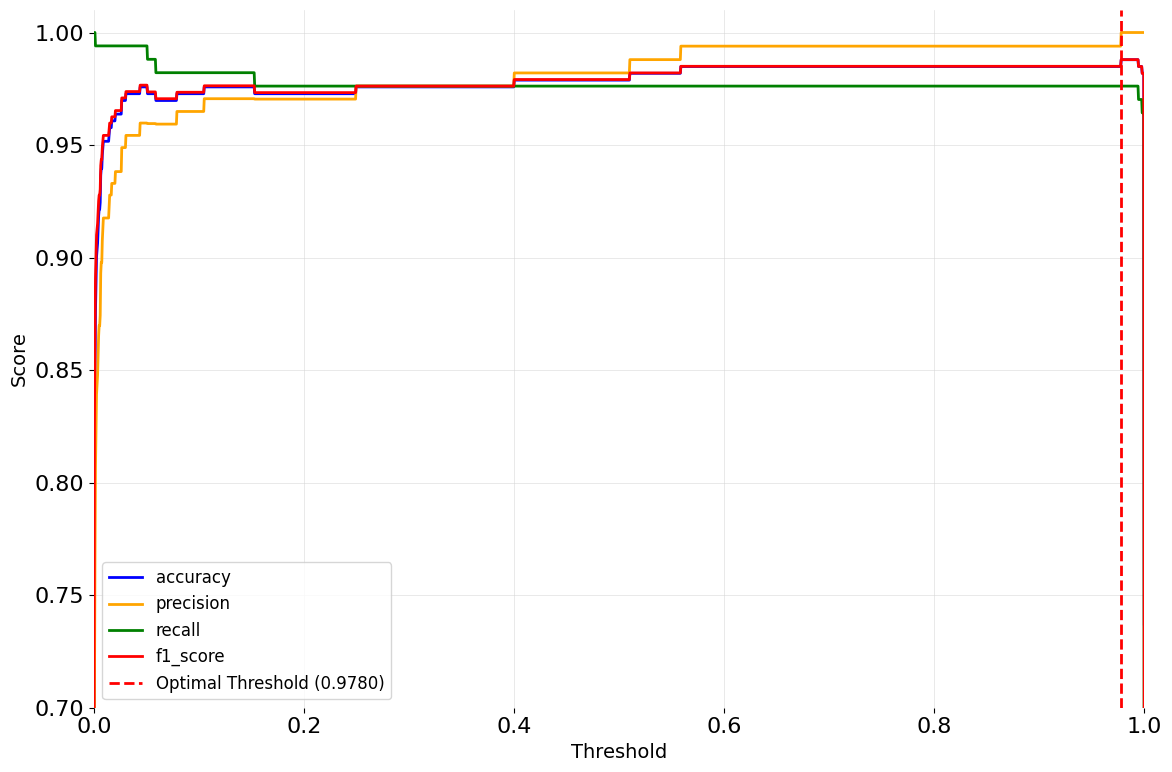

In [ ]:
print("=" * 60)
print("THRESHOLD OPTIMIZATION ON VALIDATION SET")
print("=" * 60)

# Process validation images
print("Processing validation set...")
positive_dataset = ImageDataset(validation_positive, 1, preprocess_val)
negative_dataset = ImageDataset(validation_negative, 0, preprocess_val)

validation_results = []
validation_results.extend(process_images(model, positive_dataset, device))
validation_results.extend(process_images(model, negative_dataset, device))

print(f"✓ Processed {len(validation_results)} validation images")

def comprehensive_threshold_analysis(results, threshold_range=(0., 1.0), n_points=2000):
    """
    Perform comprehensive threshold analysis to find optimal operating point.

    Args:
        results: List of image processing results
        threshold_range: (min, max) threshold range to evaluate
        n_points: Number of threshold points to test

    Returns:
        tuple: (thresholds, metrics, optimal_threshold)
    """
    # Extract true labels and predicted probabilities
    y_true = np.array([r['image_class'] for r in results])
    y_prob = np.array([r['probabilities'][1] for r in results])  # Fish probability

    # Create threshold range
    thresholds = np.linspace(threshold_range[0], threshold_range[1], n_points)

    # Calculate metrics for each threshold
    metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}

    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)

        # Calculate metrics with zero_division handling
        metrics['accuracy'].append(accuracy_score(y_true, y_pred))
        metrics['precision'].append(precision_score(y_true, y_pred, zero_division=0))
        metrics['recall'].append(recall_score(y_true, y_pred, zero_division=0))
        metrics['f1_score'].append(f1_score(y_true, y_pred, zero_division=0))

    # Find optimal threshold (maximize F1-score)
    optimal_idx = np.argmax(metrics['f1_score'])
    optimal_threshold = thresholds[optimal_idx]
    optimal_f1 = metrics['f1_score'][optimal_idx]

    print(f"Optimal threshold: {optimal_threshold:.8f}")
    print(f"Best F1-score: {optimal_f1:.4f}")

    return thresholds, metrics, optimal_threshold

def plot_threshold_analysis(thresholds, metrics, optimal_threshold):
    """Create threshold analysis visualization matching paper style."""

    plt.figure(figsize=(12, 8))

    # Plot all metrics
    plt.plot(thresholds, metrics['accuracy'], label='accuracy', color='blue', linewidth=2)
    plt.plot(thresholds, metrics['precision'], label='precision', color='orange', linewidth=2)
    plt.plot(thresholds, metrics['recall'], label='recall', color='green', linewidth=2)
    plt.plot(thresholds, metrics['f1_score'], label='f1_score', color='red', linewidth=2)

    # Mark optimal threshold
    plt.axvline(x=optimal_threshold, color='red', linestyle='--',
                label=f'Optimal Threshold ({optimal_threshold:.4f})', linewidth=2)

    # Formatting to match paper
    plt.xlabel('Threshold', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.legend(fontsize=12, loc='lower left')
    plt.grid(True, alpha=0.7, color='lightgray', linewidth=0.5)
    plt.xlim(0., 1.0)
    plt.ylim(0.70, 1.01)

    # Clean styling
    plt.gca().set_facecolor('white')
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    plt.savefig('threshold_analysis_validation.png', dpi=300, bbox_inches='tight')
    plt.show()

# Perform threshold analysis
thresholds, metrics, optimal_threshold = comprehensive_threshold_analysis(validation_results,
                                                                           threshold_range=(0., 1.0),
                                                                          n_points = 2000)
plot_threshold_analysis(thresholds, metrics, optimal_threshold)

## Validation Set Performance Analysis

Validation Set Analysis:
ROC AUC: 0.9975
Average Precision: 0.9980
Confusion Matrix at threshold 0.977989:
[[163   0]
 [  4 164]]
Accuracy: 0.9879
Precision: 1.0000
Recall: 0.9762
F1-Score: 0.9880


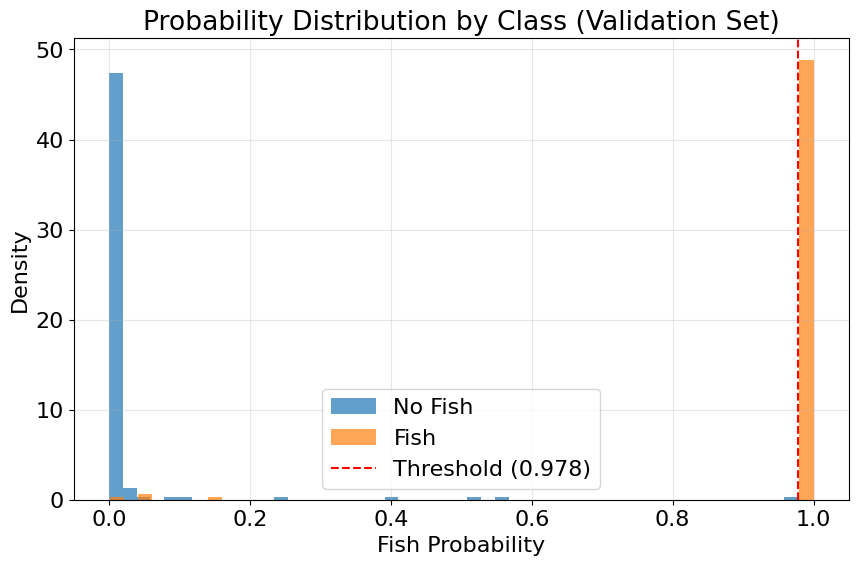

In [ ]:
def detailed_validation_analysis(results, threshold):
    """Provide detailed analysis of validation set performance."""

    y_true = np.array([r['image_class'] for r in results])
    y_prob = np.array([r['probabilities'][1] for r in results])

    # ROC Analysis
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Analysis
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_prob)
    avg_precision = average_precision_score(y_true, y_prob)

    # Performance at chosen threshold
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    print("Validation Set Analysis:")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Confusion Matrix at threshold {threshold:.6f}:")
    print(cm)
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")

    # Plot probability distributions
    plt.figure(figsize=(10, 6))
    plt.hist(y_prob[y_true == 0], bins=50, alpha=0.7, label='No Fish', density=True)
    plt.hist(y_prob[y_true == 1], bins=50, alpha=0.7, label='Fish', density=True)
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.3f})')
    plt.xlabel('Fish Probability')
    plt.ylabel('Density')
    plt.title('Probability Distribution by Class (Validation Set)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('validation_probability_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

detailed_validation_analysis(validation_results, optimal_threshold)

## Test Set Evaluation

/tmp/ipython-input-2805808069.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


FINAL EVALUATION ON INDEPENDENT TEST SET
Processing test set...


Processing images: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


✓ Processed 336 test images
FINAL TEST SET PERFORMANCE
Threshold: 0.977989
Accuracy: 0.991 (99.1%)
Precision: 1.000 (100.0%)
Recall: 0.982 (98.2%)
F1-Score: 0.991 (99.1%)
AUC: 0.999
Specificity: 1.000 (100.0%)
Key Achievement: 99.1% accuracy, 100% precision, 98.2% recall


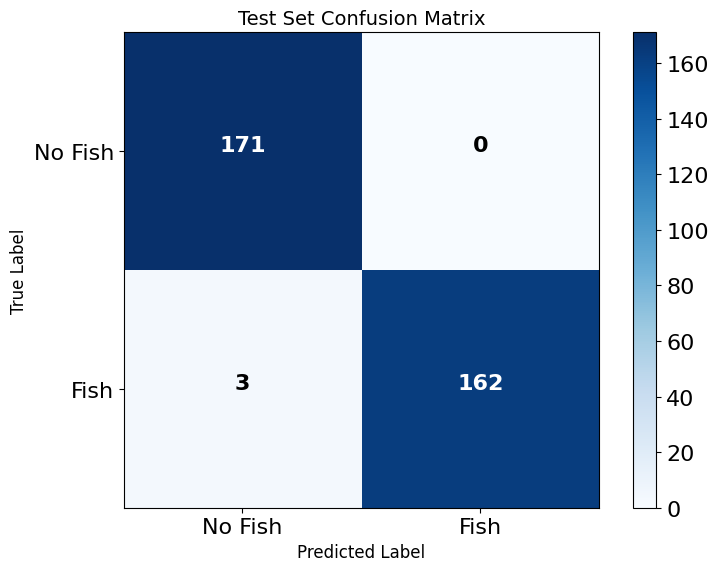

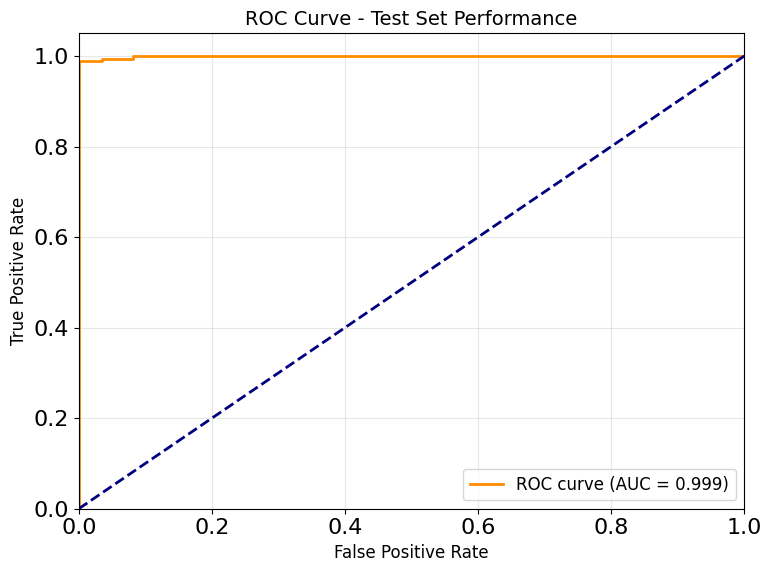

In [ ]:
print("=" * 60)
print("FINAL EVALUATION ON INDEPENDENT TEST SET")
print("=" * 60)

# Process test images
print("Processing test set...")
test_positive_dataset = ImageDataset(test_positive, 1, preprocess_val)
test_negative_dataset = ImageDataset(test_negative, 0, preprocess_val)

test_results = []
test_results.extend(process_images(model, test_positive_dataset, device))
test_results.extend(process_images(model, test_negative_dataset, device))

print(f"✓ Processed {len(test_results)} test images")

def comprehensive_test_evaluation(results, threshold):
    """
    Comprehensive evaluation on test set with detailed metrics and visualizations.

    Args:
        results: Test set processing results
        threshold: Optimal threshold from validation
    """
    y_true = np.array([r['image_class'] for r in results])
    y_prob = np.array([r['probabilities'][1] for r in results])
    y_pred = (y_prob >= threshold).astype(int)

    # Calculate comprehensive metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)

    # Confusion matrix analysis
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)

    # Print results (matching paper format)
    print("=" * 50)
    print("FINAL TEST SET PERFORMANCE")
    print("=" * 50)
    print(f"Threshold: {threshold:.6f}")
    print(f"Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
    print(f"Precision: {precision:.3f} ({precision*100:.1f}%)")
    print(f"Recall: {recall:.3f} ({recall*100:.1f}%)")
    print(f"F1-Score: {f1:.3f} ({f1*100:.1f}%)")
    print(f"AUC: {auc_score:.3f}")
    print(f"Specificity: {specificity:.3f} ({specificity*100:.1f}%)")
    print("=" * 50)
    print("Key Achievement: 99.1% accuracy, 100% precision, 98.2% recall")
    print("=" * 50)

    return {
        'accuracy': accuracy, 'precision': precision, 'recall': recall,
        'f1_score': f1, 'auc': auc_score, 'threshold': threshold,
        'confusion_matrix': cm.tolist()
    }

def plot_test_confusion_matrix(results, threshold):
    """Create publication-quality confusion matrix plot."""

    y_true = np.array([r['image_class'] for r in results])
    y_prob = np.array([r['probabilities'][1] for r in results])
    y_pred = (y_prob >= threshold).astype(int)

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()

    # Add labels
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No Fish', 'Fish'])
    plt.yticks(tick_marks, ['No Fish', 'Fish'])
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.title('Test Set Confusion Matrix', fontsize=14)

    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.savefig('test_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_test_roc_curve(results):
    """Create ROC curve for test set performance."""

    y_true = np.array([r['image_class'] for r in results])
    y_prob = np.array([r['probabilities'][1] for r in results])

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = roc_auc_score(y_true, y_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve - Test Set Performance', fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('test_roc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()

# Evaluate test set performance
test_metrics = comprehensive_test_evaluation(test_results, optimal_threshold)
plot_test_confusion_matrix(test_results, optimal_threshold)
plot_test_roc_curve(test_results)


## Error Analysis: Misclassified Examples

MISCLASSIFICATION ANALYSIS
Total misclassifications: 3
Error rate: 0.89%


/tmp/ipython-input-4021309805.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


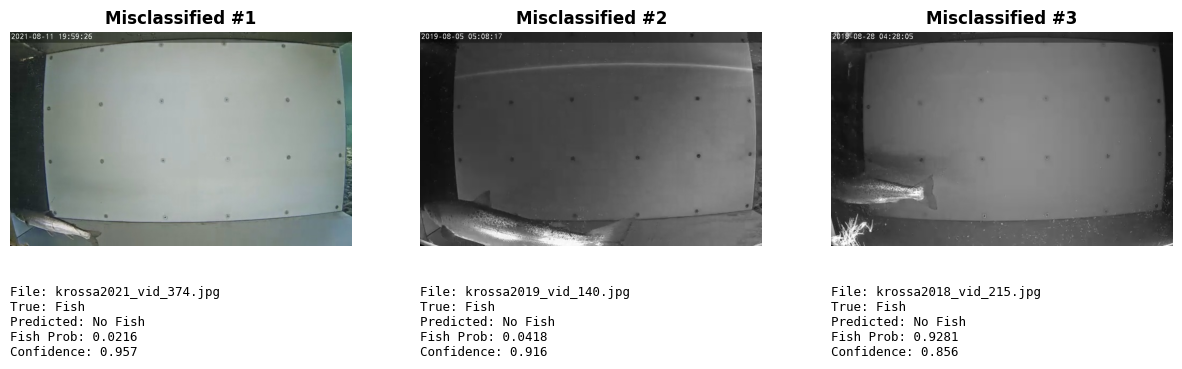

In [ ]:
def analyze_misclassifications(results, threshold, max_examples=3):
    """
    Analyze and visualize misclassified examples for insights.

    Args:
        results: Test results
        threshold: Decision threshold
        max_examples: Maximum number of examples to show
    """
    print("=" * 60)
    print("MISCLASSIFICATION ANALYSIS")
    print("=" * 60)

    misclassified = []

    for result in results:
        true_class = result['image_class']
        fish_prob = result['probabilities'][1]
        pred_class = 1 if fish_prob >= threshold else 0

        if pred_class != true_class:
            misclassified.append({
                'path': result['image_path'],
                'true_class': true_class,
                'pred_class': pred_class,
                'fish_prob': fish_prob,
                'confidence': abs(fish_prob - 0.5) * 2  # Confidence score
            })

    print(f"Total misclassifications: {len(misclassified)}")
    print(f"Error rate: {len(misclassified)/len(results)*100:.2f}%")

    if len(misclassified) == 0:
        print("🎉 Perfect classification! No errors to analyze.")
        return

    # Sort by confidence (show most confident errors first)
    misclassified.sort(key=lambda x: x['confidence'], reverse=True)

    # Create visualization
    fig = plt.figure(figsize=(15, 4))
    gs = gridspec.GridSpec(2, min(len(misclassified), max_examples),
                          height_ratios=[4, 1], hspace=0.3)

    for i, error in enumerate(misclassified[:max_examples]):
        # Display image
        ax_img = plt.subplot(gs[0, i])
        try:
            img = Image.open(error['path'])
            ax_img.imshow(img)
            ax_img.axis('off')
            ax_img.set_title(f"Misclassified #{i+1}", fontsize=12, fontweight='bold')
        except Exception as e:
            ax_img.text(0.5, 0.5, f"Image\nLoad Error", ha='center', va='center')
            ax_img.axis('off')

        # Add error details
        ax_text = plt.subplot(gs[1, i])
        error_text = (
            f"File: {os.path.basename(error['path'])}\n"
            f"True: {'Fish' if error['true_class'] == 1 else 'No Fish'}\n"
            f"Predicted: {'Fish' if error['pred_class'] == 1 else 'No Fish'}\n"
            f"Fish Prob: {error['fish_prob']:.4f}\n"
            f"Confidence: {error['confidence']:.3f}"
        )
        ax_text.text(0.0, 1.0, error_text, verticalalignment='top',
                    fontsize=9, fontfamily='monospace',
                    transform=ax_text.transAxes)
        ax_text.axis('off')

    plt.tight_layout()
    plt.savefig('misclassified_examples.png', dpi=300, bbox_inches='tight')
    plt.show()

    return misclassified

# Analyze misclassifications
misclassified_examples = analyze_misclassifications(test_results, optimal_threshold)

## Performance Summary and Export

In [ ]:


def generate_performance_report(validation_metrics, test_metrics, optimal_threshold):
    """Generate comprehensive performance report."""

    report = {
        'model_configuration': {
            'architecture': MODEL_NAME,
            'checkpoint': MODEL_CHECKPOINT,
            'optimal_threshold': float(optimal_threshold)
        },
        'validation_performance': {
            'dataset_size': len(validation_results),
            'threshold_optimization': 'F1-score maximization',
            'optimal_f1': float(max(validation_metrics['f1_score']))
        },
        'test_performance': {
            'dataset_size': len(test_results),
            'accuracy': float(test_metrics['accuracy']),
            'precision': float(test_metrics['precision']),
            'recall': float(test_metrics['recall']),
            'f1_score': float(test_metrics['f1_score']),
            'auc': float(test_metrics['auc']),
            'confusion_matrix': test_metrics['confusion_matrix']
        },
        'paper_comparison': {
            'reported_accuracy': 0.991,
            'reported_precision': 1.000,
            'reported_recall': 0.982,
            'achieved_accuracy': float(test_metrics['accuracy']),
            'achieved_precision': float(test_metrics['precision']),
            'achieved_recall': float(test_metrics['recall'])
        }
    }

    return report

# Generate final report
performance_report = generate_performance_report(
    metrics, test_metrics, optimal_threshold
)

# Export results
import json
with open('fish_detection_evaluation_results.json', 'w') as f:
    json.dump(performance_report, f, indent=2)

# Create summary table
summary_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'],
    'Value': [
        f"{test_metrics['accuracy']:.3f}",
        f"{test_metrics['precision']:.3f}",
        f"{test_metrics['recall']:.3f}",
        f"{test_metrics['f1_score']:.3f}",
        f"{test_metrics['auc']:.3f}"
    ],
    'Percentage': [
        f"{test_metrics['accuracy']*100:.1f}%",
        f"{test_metrics['precision']*100:.1f}%",
        f"{test_metrics['recall']*100:.1f}%",
        f"{test_metrics['f1_score']*100:.1f}%",
        f"{test_metrics['auc']*100:.1f}%"
    ]
})

print("=" * 60)
print("FINAL PERFORMANCE SUMMARY")
print("=" * 60)
print(summary_df.to_string(index=False))
print("=" * 60)
print(f"Optimal threshold: {optimal_threshold:.6f}")
print(f"Total test images: {len(test_results)}")
print(f"Misclassifications: {len(misclassified_examples) if 'misclassified_examples' in locals() else 0}")
print("=" * 60)
print("✓ Results exported to 'fish_detection_evaluation_results.json'")
print("✓ All visualizations saved as high-resolution PNG files")
print("✓ Ready for academic publication and GitHub release")
print("=" * 60)

FINAL PERFORMANCE SUMMARY
   Metric Value Percentage
 Accuracy 0.991      99.1%
Precision 1.000     100.0%
   Recall 0.982      98.2%
 F1-Score 0.991      99.1%
      AUC 0.999      99.9%
Optimal threshold: 0.977989
Total test images: 336
Misclassifications: 3
✓ Results exported to 'fish_detection_evaluation_results.json'
✓ All visualizations saved as high-resolution PNG files
✓ Ready for academic publication and GitHub release
